# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *
from online_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# rides = pd.read_csv('../data/rideshare_kaggle.csv')
# rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

# new_rides = rides[['hour','cab_type','price','distance','date']].dropna(subset = ['price']).reset_index()
# new_rides['distance'] = new_rides.progress_apply(lambda row: math.ceil(row['distance']), axis=1)
# new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

# cab_types_ = new_rides.cab_type.unique()
# distances_ = new_rides.distance.unique()
# hours_ = np.array([16,17,18,19,20])  # new_rides.hour.unique()
# prices_ = np.array([5*(i) for i in range(10)])  # new_rides.price.unique()
# dates = len(new_rides.date.unique())

# g = np.zeros((len(cab_types_),len(prices_),len(hours_),len(distances_)))

# for i in range(len(cab_types_)):
#     for j in trange(len(prices_)):
#         for k in range(len(hours_)):
#             for m in range(len(distances_)):
#                 g[i,j,k,m] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
#                                           &(new_rides['price']==prices_[j])
#                                           &(new_rides['hour']==hours_[k])
#                                           &(new_rides['distance']==distances_[m])])/dates

# np.random.seed(37)

In [3]:
rides = pd.read_csv('../data/rideshare_kaggle.csv')
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

new_rides = rides[['source','destination','cab_type','price','date']].dropna(subset = ['price']).reset_index()
new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

cab_types_ = new_rides.cab_type.unique()
sources_ = new_rides.source.unique()
destinations_ = new_rides.destination.unique()
prices_ = np.array([25+5*(i+1) for i in range(5)])
dates = len(new_rides.date.unique())

g = np.zeros((len(cab_types_),len(prices_),len(sources_)))

for i in range(len(cab_types_)):
    for j in trange(len(prices_)):
        for k in range(len(sources_)):
                g[i,j,k] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
                                            &(new_rides['price']==prices_[j])
                                            &(new_rides['source']==sources_[k])])/dates

np.random.seed(37)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]


# Configurations

In [4]:
g_uber = g[np.where(cab_types_=='Uber'),:,:].squeeze().reshape(-1,1)
g_lyft = g[np.where(cab_types_=='Lyft'),:,:].squeeze().reshape(-1,1)

prices_ = (prices_.reshape((-1,1))*np.ones((len(prices_),len(sources_)))).reshape(-1,1)

# print(f'g_uber = \n{g_uber}')
# print(f'g_lyft = \n{g_lyft}')
# print(prices_)

d_1 = len(g_uber)  # Dimension of each player's data/strategy
d_2 = len(g_lyft)

lambda_p1 = 1e0
lambda_p2 = 1e0

eta_p1 = 1e-2
eta_p2 = 1e-2

mu_p1 = -0.3*g_uber
gamma_p1 = 0.1*g_lyft
mu_p2 = -0.3*g_lyft
gamma_p2 = 0.1*g_uber

# print(f'mu_1 = \n{mu_p1}')
# print(f'gamma_1 = \n{gamma_p1}')
# print(f'mu_2 = \n{mu_p2}')
# print(f'gamma_2 = \n{gamma_p2}')

In [5]:
p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)
p1_data_generating_func = sample_from_location_family_rideshare

p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
p2_data_generating_func = sample_from_location_family_rideshare

In [6]:
num_rounds_lst = np.logspace(1,5,5,dtype='int')
num_test = 1000
num_alternate_rounds = 1000

# Run game with 2-stage algorithm

In [7]:
np.random.seed(0)
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_samples in num_rounds_lst:
    print(f"num_samples = {num_samples}")
    rounds_1 = max(math.floor(0.8*num_samples),num_samples-1000)
    rounds_2 = num_samples-rounds_1
    player_one = TwoStagePlayer()
    player_two = TwoStagePlayer()
    game_ts = DecisionDependentGame(player_one, player_two,
                                    p1_data_params, p2_data_params,
                                    p1_data_generating_func, p2_data_generating_func,
                                    num_rounds=rounds_1, num_alternate_rounds=rounds_2, num_test=1000)
    
    game_ts.run_train()
    game_ts.run_post_train_alternating()
    
    PR1 = game_ts.evaluate_perf_risk_p1()
    PR2 = game_ts.evaluate_perf_risk_p2()
    
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game_ts.theta_p1)
    theta_final_p2.append(game_ts.theta_p2)
    
    #Change this flag if one wants to change print settings
    if True:
        print("---------------------")
        print("Player 1: mu error")
        print(np.linalg.norm(mu_p1-player_one.mu_hat))
        print("Player 1: gamma error")
        print(np.linalg.norm(gamma_p1-player_one.gamma_hat))
        print("Player 1 Risk:")
        print(PR1)

        print("Player 2: mu error")
        print(np.linalg.norm(mu_p2-player_two.mu_hat))
        print("Player 2: gamma error")
        print(np.linalg.norm(gamma_p2-player_two.gamma_hat))
        print("Player 2 Risk:")
        print(PR2)
        print("---------------------")

num_samples = 10
---------------------
Player 1: mu error
54.80888201670363
Player 1: gamma error
61.81286237675233
Player 1 Risk:
-66140.60787037818
Player 2: mu error
64.04682266273561
Player 2: gamma error
83.04216282703865
Player 2 Risk:
-130567.1963403165
---------------------
num_samples = 100
---------------------
Player 1: mu error
6.268510097119937
Player 1: gamma error
6.900294685973832
Player 1 Risk:
-73616.30737278277
Player 2: mu error
7.492925267355461
Player 2: gamma error
6.00334983537989
Player 2 Risk:
-130770.14571831728
---------------------
num_samples = 1000
---------------------
Player 1: mu error
1.7967983377839587
Player 1: gamma error
1.4673113211143527
Player 1 Risk:
-73683.87382994694
Player 2: mu error
1.8025821735746874
Player 2: gamma error
2.578123077474273
Player 2 Risk:
-130795.9696077798
---------------------
num_samples = 10000
---------------------
Player 1: mu error
0.4474247026841856
Player 1: gamma error
0.5212581105725802
Player 1 Risk:
-74044.05

# Run game with DFO players

In [8]:
np.random.seed(0)
p3_risks = []
p4_risks = []
theta_final_p3 = []
theta_final_p4 = []

delta = 4e-1
eta = 1e-2#1e-1 best so far
num_test_dfo = 100
num_rounds = num_rounds_lst[-1]

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_test = num_test_dfo)

# print(game_dfo.theta_p1)

for i in trange(math.ceil(num_rounds/2/num_test_dfo)+1):

    theta31, theta32 = player_three.perturb_theta()
    theta41, theta42 = player_four.perturb_theta()
    
    game_dfo.theta_p1 = theta31
    game_dfo.theta_p2 = theta41
    pr31 = game_dfo.evaluate_perf_risk_p1()
    pr41 = game_dfo.evaluate_perf_risk_p2()
    
    game_dfo.theta_p1 = theta32
    game_dfo.theta_p2 = theta42
    pr32 = game_dfo.evaluate_perf_risk_p1()
    pr42 = game_dfo.evaluate_perf_risk_p2()
#     print(pr31)
#     print(pr32)
    
    game_dfo.theta_p1 = player_three.update_theta(pr31, pr32)
    game_dfo.theta_p2 = player_four.update_theta(pr41, pr42)
#     print(game_dfo.theta_p1)
    
    if i*2*num_test_dfo >= num_rounds_lst[len(p3_risks)]:
#         p3_risks.append(evaluate_performative_risk(p1_data_generating_func, g_uber, prices_,
#                                                    mu_p1, gamma_p1,
#                                                    lambda_p1,
#                                                    game_dfo.theta_p1, game_dfo.theta_p2,
#                                                    num_test))
#         p4_risks.append(evaluate_performative_risk(p2_data_generating_func, g_lyft, prices_,
#                                                    mu_p2, gamma_p2,
#                                                    lambda_p2,
#                                                    game_dfo.theta_p2, game_dfo.theta_p1,
#                                                    num_test))
        p3_risks.append(np.mean(np.array(game_dfo.p1.risk_history[max(-i,-1000)])))
        p4_risks.append(np.mean(np.array(game_dfo.p2.risk_history[max(-i,-1000)])))
        
        theta_final_p3.append(game_dfo.theta_p1)
        theta_final_p4.append(game_dfo.theta_p2)

        if False:
            print("---------------------")
            print(f"Iteration {i*2*num_test_dfo}")
            print("Player 3 risk:")
            print(p3_risks[-1])

            print("Player 4 risk:")
            print(p4_risks[-1])
            print("---------------------")
            
# print(np.mean(game_dfo.p1.theta_history))
# print(np.mean(game_dfo.p2.theta_history))
# theta_final_p3[-1] = np.mean(game_dfo.p1.theta_history)
# theta_final_p4[-1] = np.mean(game_dfo.p2.theta_history)

100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 558.51it/s]


# Run game with Online players

In [9]:
np.random.seed(0)
p5_risks = []
p6_risks = []
theta_final_p5 = []
theta_final_p6 = []

nu = 1e-2
eta = 1e-1
n = 100
B = 0.1
R = 5
num_rounds = num_rounds_lst[-1]

player_five = OnlinePlayer(d_1, d_1+d_2, d_1, eta, nu, n, B, R)
player_six = OnlinePlayer(d_2, d_1+d_2, d_2, eta, nu, n, B, R)
game_online = DecisionDependentGame(player_five, player_six,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_test = 1000)

for i in trange(math.ceil(num_rounds/(n))+1):

    theta_5, u_5k = player_five.perturb_theta()
    theta_6, u_6k = player_six.perturb_theta()
#     print(f'theta {theta_5.shape}')
    
    z_5k = []
    z_6k = []
    for j in range(n):
        game_online.theta_p1 = theta_5+(u_5k[:,j]).reshape((-1,1))
        game_online.theta_p2 = theta_5+(u_6k[:,j]).reshape((-1,1))
        
        z_5k.append(game_online.oracle_z1())
        z_6k.append(game_online.oracle_z2())
        
#     print(f'z {len(z_5k)}')
        
    q_5k = player_five.compute_aux_q(z_5k, theta_6, u_6k)
    q_6k = player_six.compute_aux_q(z_6k, theta_5, u_5k)
#     print(f'q {q_5k.shape}')
    
    p_5 = player_five.update_p()
    p_6 = player_six.update_p()
#     print(f'p {p_5.shape}')
    
    grad_5 = game_online.oracle_grad1(p_5, q_5k)
    grad_6 = game_online.oracle_grad2(p_6, q_6k)
#     print(f'grad {grad_5.shape}')
    
    game_online.theta_p1 = player_five.update_theta(grad_5)
    game_online.theta_p2 = player_six.update_theta(grad_6)
#     print(f'theta {game_online.theta_p1.shape}')
    
    if i*n >= num_rounds_lst[len(p5_risks)]:
        p5_risks.append(game_online.evaluate_perf_risk_p1())
        p6_risks.append(game_online.evaluate_perf_risk_p2())
        
        theta_final_p5.append(game_online.theta_p1)
        theta_final_p6.append(game_online.theta_p2)
    
        if False:
            print("---------------------")
            print(f"Iteration {i*n}")
            print("Player 5: mu error")
            print(np.linalg.norm(mu_p1-p_5[:,:d_1].reshape((-1,1))))
            print("Player 5: gamma error")
            print(np.linalg.norm(gamma_p1-p_5[:,d_1:].reshape((-1,1))))
            print("Player 5 risk:")
            print(p5_risks[-1])

            print("Player 6: mu error")
            print(np.linalg.norm(mu_p2-p_6[:,:d_2].reshape((-1,1))))
            print("Player 6: gamma error")
            print(np.linalg.norm(gamma_p2-p_6[:,d_2:].reshape((-1,1))))
            print("Player 6 risk:")
            print(p6_risks[-1])
            print("---------------------")

100%|█████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:08<00:00, 124.83it/s]


## Plots

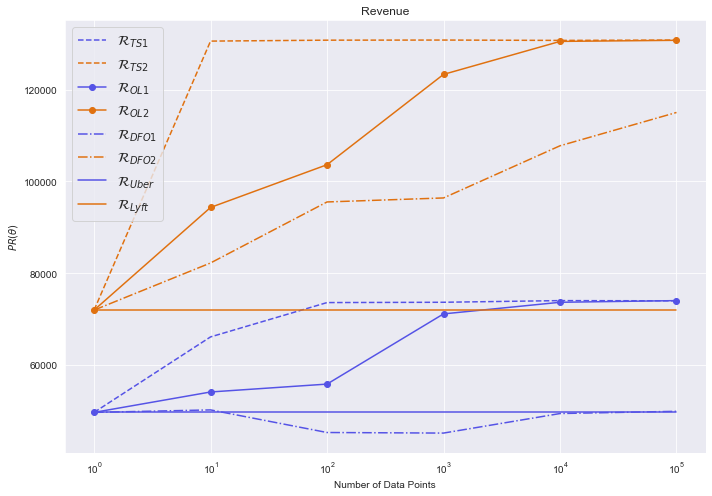

In [10]:
base_uber = -np.dot(g_uber.T,prices_)[0,0]
base_lyft = -np.dot(g_lyft.T,prices_)[0,0]

num_rounds_lst_ = num_rounds_lst

num_rounds_lst_ = np.insert(num_rounds_lst,0,1)
p1_risks_ = np.insert(p1_risks, 0, base_uber)
p2_risks_ = np.insert(p2_risks, 0, base_lyft)
p3_risks_ = np.insert(p3_risks, 0, base_uber)
p4_risks_ = np.insert(p4_risks, 0, base_lyft)
p5_risks_ = np.insert(p5_risks, 0, base_uber)
p6_risks_ = np.insert(p6_risks, 0, base_lyft)

plt.figure(figsize=(10,7))
# plt.subplot(1,2,1)
plt.semilogx(num_rounds_lst_, -np.squeeze(p1_risks_),
             '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.semilogx(num_rounds_lst_, -np.squeeze(p2_risks_),
             '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.semilogx(num_rounds_lst_, -np.squeeze(p5_risks_),
             '-o', color='#5553E6', label=r'$\mathcal{R}_{OL1}$')
plt.semilogx(num_rounds_lst_, -np.squeeze(p6_risks_),
             '-o', color='#E07110', label=r'$\mathcal{R}_{OL2}$')

plt.semilogx(num_rounds_lst_, -np.squeeze(p3_risks_),
             '-.', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.semilogx(num_rounds_lst_, -np.squeeze(p4_risks_),
             '-.', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.semilogx(num_rounds_lst_, [np.dot(g_uber.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
             '-', color='#5553E6', label=r'$\mathcal{R}_{Uber}$')
plt.semilogx(num_rounds_lst_, [np.dot(g_lyft.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
             '-', color='#E07110', label=r'$\mathcal{R}_{Lyft}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$PR(\theta)$")
plt.title("Revenue")
plt.legend(fontsize=14)

# plt.subplot(1,2,2)
# plt.loglog(num_rounds_lst_, -np.squeeze(p1_risks_),
#            '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
# plt.loglog(num_rounds_lst_, -np.squeeze(p2_risks_),
#            '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

# plt.loglog(num_rounds_lst_, -np.squeeze(p5_risks_),
#            '-o', color='#5553E6', label=r'$\mathcal{R}_{OL1}$')
# plt.loglog(num_rounds_lst_, -np.squeeze(p6_risks_),
#            '-o', color='#E07110', label=r'$\mathcal{R}_{OL2}$')

# plt.loglog(num_rounds_lst_, -np.squeeze(p3_risks_),
#              '-.', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
# plt.loglog(num_rounds_lst_, -np.squeeze(p4_risks_),
#              '-.', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

# plt.loglog(num_rounds_lst_, [np.dot(g_uber.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
#              '-', color='#5553E6', label=r'$\mathcal{R}_{Uber}$')
# plt.loglog(num_rounds_lst_, [np.dot(g_lyft.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
#              '-', color='#E07110', label=r'$\mathcal{R}_{Lyft}$')

# plt.xlabel("Number of Data Points")
# plt.ylabel(r"$\log(PR(\theta))$")
# plt.title('Revenue')
# plt.legend(fontsize=14)

# plt.subplot(1,3,3)
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p1),
#            '--', color='#5553E6', label=r'$\theta_{TS1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p2),
#            '--', color='#E07110', label=r'$\theta_{TS2}$')

# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p3),
#            '-', color='#5553E6', label=r'$\theta_{DFO1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p4),
#            '-', color='#E07110', label=r'$\theta_{DFO2}$')

# plt.ylim(-10,10)
# plt.xlabel("Number of Data Points")
# plt.ylabel(r"$\log(PR(\theta))$")
# plt.title('Strategies')
# plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

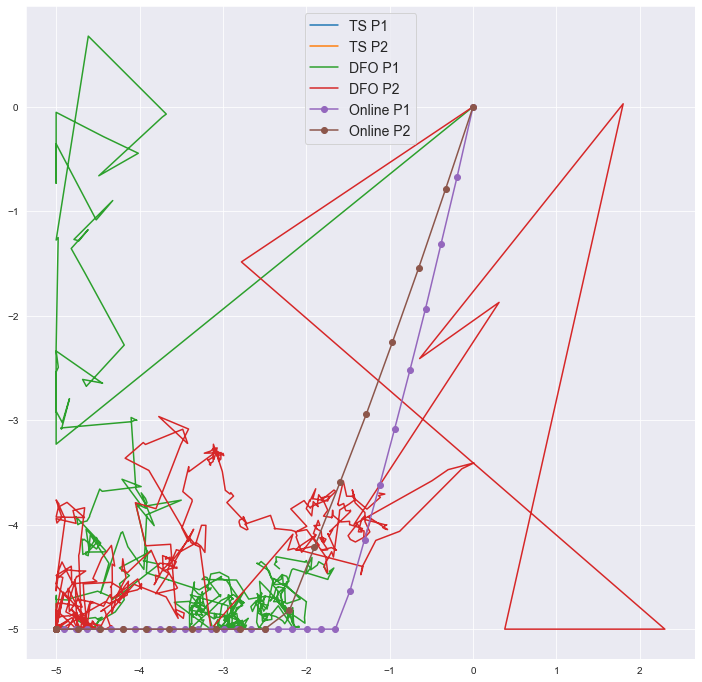

In [11]:
plt.figure(figsize=(12,12))
plt.plot(np.array(theta_final_p1)[:,0].squeeze(),
         np.array(theta_final_p1)[:,1].squeeze(), label='TS P1')
plt.plot(np.array(theta_final_p2)[:,0].squeeze(),
         np.array(theta_final_p2)[:,1].squeeze(), label='TS P2')
plt.plot(np.array(game_dfo.p1.theta_history)[:,0].squeeze(),
         np.array(game_dfo.p1.theta_history)[:,1].squeeze(), label='DFO P1')
plt.plot(np.array(game_dfo.p2.theta_history)[:,0].squeeze(),
         np.array(game_dfo.p2.theta_history)[:,1].squeeze(), label='DFO P2')
plt.plot(np.array(game_online.p1.theta_history)[:,0].squeeze(),
         np.array(game_online.p1.theta_history)[:,1].squeeze(), '-o', label='Online P1')
plt.plot(np.array(game_online.p2.theta_history)[:,0].squeeze(),
         np.array(game_online.p2.theta_history)[:,1].squeeze(), '-o', label='Online P2')
# plt.xlim(-5.1,5.1)
# plt.ylim(-5.1,5.1)
plt.legend(fontsize=14)
plt.show()

In [12]:
g[np.where(cab_types_=='Uber'),:,:].squeeze()

array([[2.38823529e+01, 8.32352941e+01, 3.92352941e+01, 6.85882353e+01,
        5.25294118e+01, 1.45941176e+02, 1.33588235e+02, 6.30588235e+01,
        6.31176471e+01, 8.77647059e+01, 5.69411765e+01, 1.11411765e+02],
       [2.23529412e+00, 3.00588235e+01, 2.51764706e+01, 5.67058824e+01,
        1.64705882e+00, 6.80000000e+01, 5.71176471e+01, 1.98235294e+01,
        4.29411765e+00, 2.07647059e+01, 7.72941176e+01, 5.39411765e+01],
       [3.52941176e-01, 6.88235294e+00, 7.64705882e-01, 1.29411765e+00,
        2.35294118e-01, 2.94705882e+01, 1.46470588e+01, 5.29411765e-01,
        4.11764706e-01, 5.88235294e-01, 5.00000000e+01, 1.24117647e+01],
       [1.17647059e-01, 4.35294118e+00, 1.76470588e-01, 5.29411765e-01,
        1.17647059e-01, 4.47058824e+00, 2.05882353e+00, 4.11764706e-01,
        4.11764706e-01, 3.52941176e-01, 2.88235294e+01, 2.70588235e+00],
       [1.17647059e-01, 1.23529412e+00, 1.76470588e-01, 2.35294118e-01,
        1.76470588e-01, 5.29411765e-01, 7.05882353e-01, 2.35

In [13]:
location_family_demand_rideshare(g_uber, mu_p1, gamma_p1, game_ts.theta_p1, game_ts.theta_p2).reshape((5,12))

array([[3.91470588e+01, 1.58970588e+02, 6.02352941e+01, 1.18352941e+02,
        6.29705882e+01, 2.72470588e+02, 2.43764706e+02, 9.97058824e+01,
        9.55294118e+01, 1.52882353e+02, 9.27647059e+01, 1.94264706e+02],
       [4.64705882e+00, 6.30882353e+01, 4.96470588e+01, 1.19911765e+02,
        0.00000000e+00, 1.40735294e+02, 1.16294118e+02, 3.88529412e+01,
        0.00000000e+00, 4.27647059e+01, 1.56705882e+02, 1.04352941e+02],
       [6.32647439e-01, 1.55294118e+01, 1.76450420e+00, 2.23529412e+00,
        0.00000000e+00, 6.06470588e+01, 2.45588235e+01, 1.89230709e-01,
        0.00000000e+00, 4.82593825e-01, 1.09029412e+02, 2.30000000e+01],
       [3.88055591e-02, 6.67647059e+00, 0.00000000e+00, 2.35294118e-01,
        0.00000000e+00, 1.23529412e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.90588235e+01, 6.47058824e-01],
       [1.46469828e-01, 1.29411765e+00, 2.55394174e-01, 2.00130419e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00

In [14]:
location_family_demand_rideshare(g_uber, mu_p1, gamma_p1, game_online.theta_p1, game_online.theta_p2).reshape((5,12))

array([[3.91470588e+01, 1.58970588e+02, 6.02352941e+01, 1.18352941e+02,
        6.29705882e+01, 2.72470588e+02, 2.43764706e+02, 9.97058824e+01,
        9.55294118e+01, 1.52882353e+02, 9.27647059e+01, 1.94264706e+02],
       [4.64705882e+00, 6.30882353e+01, 4.96470588e+01, 1.19911765e+02,
        0.00000000e+00, 1.40735294e+02, 1.16294118e+02, 3.88529412e+01,
        0.00000000e+00, 4.27647059e+01, 1.56705882e+02, 1.04352941e+02],
       [5.91459178e-01, 1.55294118e+01, 1.76854225e+00, 2.23529412e+00,
        0.00000000e+00, 6.06470588e+01, 2.45588235e+01, 2.33762968e-03,
        0.00000000e+00, 2.94583163e-01, 1.09029412e+02, 2.30000000e+01],
       [6.01809096e-02, 6.67647059e+00, 0.00000000e+00, 7.95977126e-02,
        0.00000000e+00, 1.23529412e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.90588235e+01, 6.47058824e-01],
       [1.53346595e-01, 1.29411765e+00, 2.55680797e-01, 1.98048583e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00

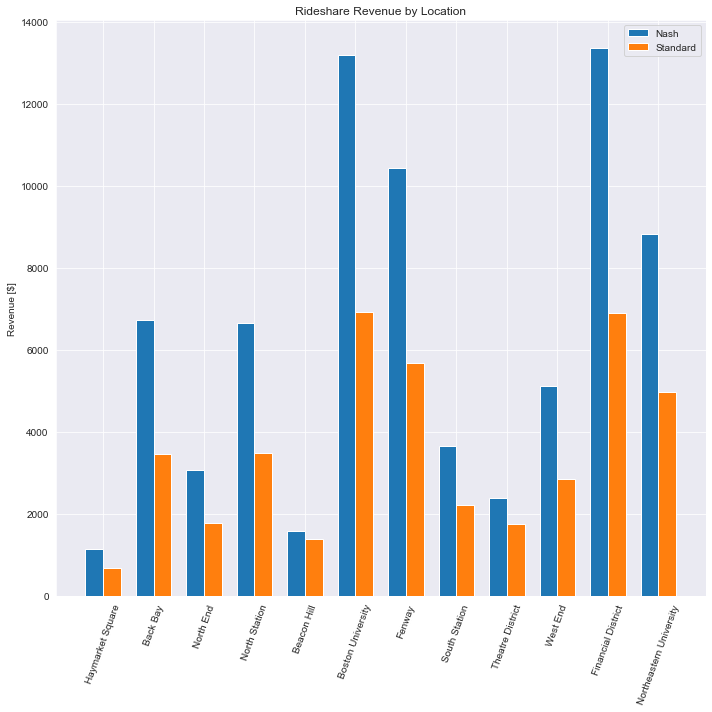

In [15]:
labels = new_rides.source.unique()
names = ['Nash', 'Standard']
uber_demands = lambda theta1, theta2, g: location_family_demand_rideshare(g, mu_p1, gamma_p1, theta1, theta2).reshape((5,12))
prices = [25+i*5 for i in range(5)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(x-width/2, (np.dot(np.array(prices),uber_demands(game_ts.theta_p1,game_ts.theta_p2,g_uber))).squeeze(), width, label=names[0])
ax.bar(x+width/2, (np.dot(np.array(prices),uber_demands(np.zeros((60,1)),np.zeros((60,1)),g_uber))).squeeze(), width, label=names[1])
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Revenue [$]')
ax.set_title('Rideshare Revenue by Location')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=70)
ax.legend()

fig.tight_layout()
plt.show()

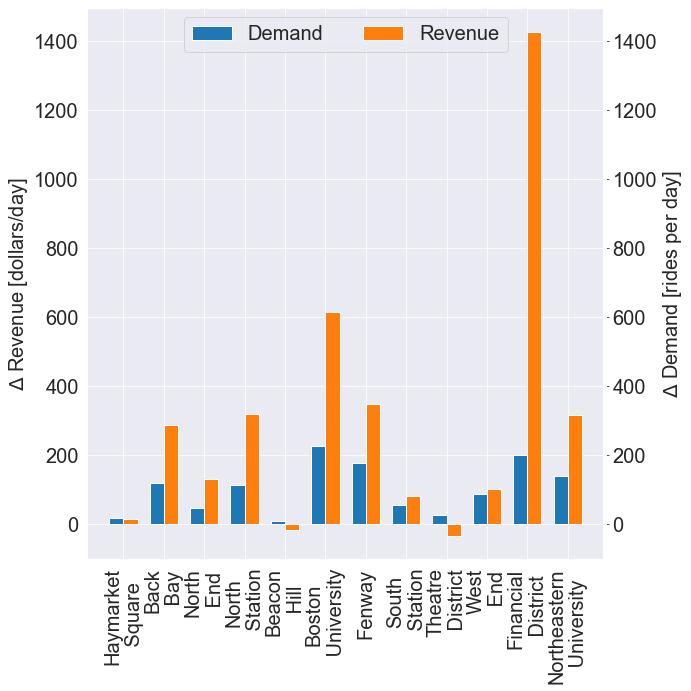

In [16]:
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 4
labels = [s.replace(' ','\n ') for s in new_rides.source.unique()]
thetas = [(game_ts.theta_p1, np.zeros((60,1))), (g_uber, g_lyft)]
names = ['Demand', 'Revenue']
uber_demands = lambda theta1, theta2, g: location_family_demand_rideshare(g, mu_p1, gamma_p1, theta1, theta2).reshape((5,12))
prices = [str(i*5) for i in range(5)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
p = np.array([j*5 for j in range(5)]).reshape((1,-1))

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(x-width/2, np.sum(uber_demands(game_ts.theta_p1, game_ts.theta_p2,g_uber)-uber_demands(np.zeros((60,1)),np.zeros((60,1)),g_uber), axis=0), width, label=names[0])
ax.bar(x+width/2, (np.dot(p,uber_demands(game_ts.theta_p1,game_ts.theta_p2,g_uber))-np.dot(p,uber_demands(np.zeros((60,1)),np.zeros((60,1)),g_uber))).squeeze(), width, label=names[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\Delta$ Revenue [dollars/day]')
# ax.set_title('Rideshare Demand by Location')
secax = ax.secondary_yaxis('right')
secax.set_ylabel(r'$\Delta$ Demand [rides per day]')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)
ax.legend(fontsize=20, loc='upper center', ncol=2)

fig.tight_layout()
plt.show()

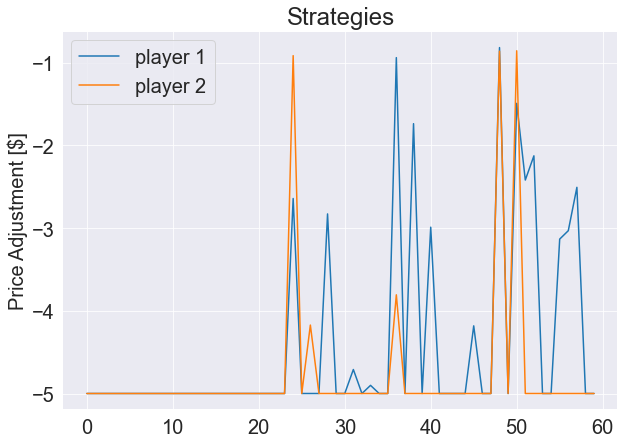

In [17]:
plt.figure(figsize=(10,7))
plt.plot(game_ts.theta_p1, label='player 1')
plt.plot(game_ts.theta_p2, label='player 2')
plt.title('Strategies')
plt.ylabel('Price Adjustment [$]')
plt.legend()
plt.show()

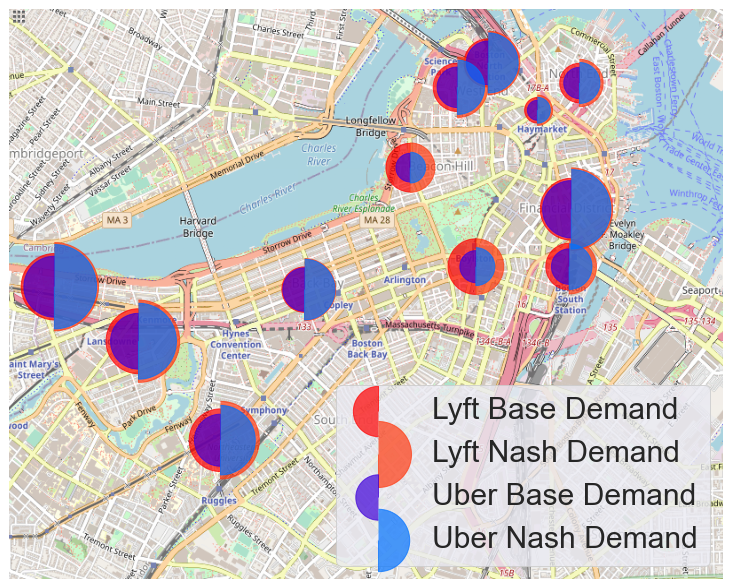

In [18]:
locations = {'Haymarket Square':(42.3628, -71.0583), 'Back Bay':(42.3503, -71.0810),
             'North End':(42.3647, -71.0542), 'North Station':(42.3661, -71.0631),
             'Beacon Hill':(42.3588, -71.0707), 'Boston University':(42.3505, -71.1054),
             'Fenway':(42.3467, -71.0972), 'South Station':(42.3519, -71.0552),
             'Theatre District':(42.3519, -71.0643), 'West End':(42.3644, -71.0661),
             'Financial District':(42.3559, -71.0550), 'Northeastern University':(42.3398, -71.0892)}

uber_nash = np.sum(uber_demands(game_ts.theta_p1, game_ts.theta_p2, g_uber), axis=0)
uber_base = np.sum(uber_demands(np.zeros((60,1)), np.zeros((60,1)), g_uber), axis=0)
lyft_nash = np.sum(uber_demands(game_ts.theta_p2, game_ts.theta_p1, g_lyft), axis=0)
lyft_base = np.sum(uber_demands(np.zeros((60,1)), np.zeros((60,1)), g_lyft), axis=0)

sources = []
lats = []
lons = []
for source, coord in locations.items():
    sources.append(source)
    lats.append(coord[0])
    lons.append(coord[1])

r1 = 1
x1 = np.cos(np.pi * np.linspace(0, r1)-np.pi/2)
y1 = np.sin(np.pi * np.linspace(0, r1)-np.pi/2)
right_c = np.row_stack([[0, 0], np.column_stack([x1, y1])])
x1 = np.cos(np.pi * np.linspace(0, r1)+np.pi/2)
y1 = np.sin(np.pi * np.linspace(0, r1)+np.pi/2)
left_c = np.row_stack([[0, 0], np.column_stack([x1, y1])])

y = np.arange(2)
width=0.35

plt.rcParams['font.size'] = 0
plt.rcParams['axes.linewidth'] = 4
# f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(10,10))
f,a0 = plt.subplots(figsize=(10,8))
im = plt.imread('boston_map.PNG')
a0.imshow(im, extent=[-71.1100, -71.0400, 42.3300, 42.3700], aspect='auto')
a0.scatter(lons, lats, marker=left_c, s=15*lyft_base, alpha=0.7, c='#FF0000', label='Lyft Base Demand')
a0.scatter(lons, lats, marker=right_c, s=15*lyft_nash, alpha=0.7, c='#FF3910', label='Lyft Nash Demand')
a0.scatter(lons, lats, marker=left_c, s=15*uber_base, alpha=0.7, c='#3E00D9', label='Uber Base Demand')
a0.scatter(lons, lats, marker=right_c, s=15*uber_nash, alpha=0.7, c='#0071FF', label='Uber Nash Demand')
a0.set_xticks([])
a0.set_yticks([])
a0.set_xticklabels([],fontsize=0)
a0.set_yticklabels([],fontsize=0)
a0.legend(loc='lower right', prop={'size': 30})

# a1.barh(y-width/2, [np.sum(uber_demands(game_ts.theta_p1,game_ts.theta_p2,g_uber)),np.sum(uber_demands(np.zeros((60,1)),np.zeros((60,1)),g_uber))],
#        width, label='Uber', color='#0071FF')
# a1.barh(y+width/2, [np.sum(uber_demands(game_ts.theta_p2,game_ts.theta_p1,g_lyft)),np.sum(uber_demands(np.zeros((60,1)),np.zeros((60,1)),g_lyft))],
#        width, label='Lyft', color='#FF3910')
# handles, labels = a1.get_legend_handles_labels()
# order = [1,0]
# a1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#           loc='lower left', ncol=1, prop={'size': 28})
# a1.set_yticks(y)
# a1.set_yticklabels(['Nash', 'Base'])
# a1.set_xlabel('Total Demand [rides/day]')

f.tight_layout()
plt.savefig('rideshare_demand_map.png', format='png')
plt.show()

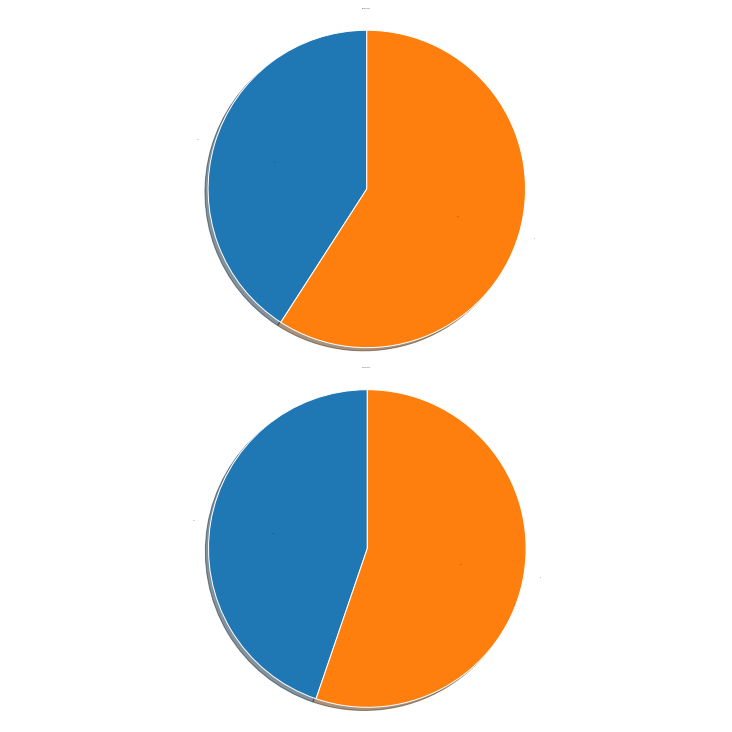

In [19]:
labels = 'Uber','Lyft'
nash = [np.sum(uber_demands(game_ts.theta_p1, game_ts.theta_p2, g_uber)), np.sum(uber_demands(game_ts.theta_p2, game_ts.theta_p1, g_lyft))]
base = [np.sum(uber_demands(np.zeros((60,1)),np.zeros((60,1)),g_uber)), np.sum(uber_demands(np.zeros((60,1)),np.zeros((60,1)),g_lyft))]

fig1, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
ax1.pie(base, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Base Market Share')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.pie(nash, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.set_title('Nash Market Share')
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.savefig('rideshare_market_share.png', format='png')
plt.show()

In [20]:
np.random.seed(0)
a = [i for i in range(-10,11,1)]
mu_p1 = -0.3*g_uber
gamma_p1 = 0.1*g_lyft
mu_p2 = -0.3*g_lyft
gamma_p2 = 0
share_gamma = []
for scale in tqdm(a):
    mu_p1 = scale*0.1*g_lyft
    p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
    p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)
    p5_risks = []
    p6_risks = []
    theta_final_p5 = []
    theta_final_p6 = []

    nu = 1e-2
    eta = 1e-1
    n = 100
    B = 0.1
    R = 500
    num_rounds = num_rounds_lst[-1]

    player_five = OnlinePlayer(d_1, d_1+d_2, d_1, eta, nu, n, B, R)
    player_six = OnlinePlayer(d_2, d_1+d_2, d_2, eta, nu, n, B, R)
    game_online = DecisionDependentGame(player_five, player_six,
                                        p1_data_params, p2_data_params,
                                        p1_data_generating_func, p2_data_generating_func,
                                        num_test = 1000)

    for i in range(math.ceil(num_rounds/(n))+1):

        theta_5, u_5k = player_five.perturb_theta()
        theta_6, u_6k = player_six.perturb_theta()
        z_5k = []
        z_6k = []
        for j in range(n):
            game_online.theta_p1 = theta_5+(u_5k[:,j]).reshape((-1,1))
            game_online.theta_p2 = theta_5+(u_6k[:,j]).reshape((-1,1))

            z_5k.append(game_online.oracle_z1())
            z_6k.append(game_online.oracle_z2())
        q_5k = player_five.compute_aux_q(z_5k, theta_6, u_6k)
        q_6k = player_six.compute_aux_q(z_6k, theta_5, u_5k)
        p_5 = player_five.update_p()
        p_6 = player_six.update_p()
        grad_5 = game_online.oracle_grad1(p_5, q_5k)
        grad_6 = game_online.oracle_grad2(p_6, q_6k)
        game_online.theta_p1 = player_five.update_theta(grad_5)
        game_online.theta_p2 = player_six.update_theta(grad_6)
        
    uber_demands = lambda theta1, theta2, g: location_family_demand_rideshare(g, mu_p1, gamma_p1, theta1, theta2).reshape((5,12))
    uber_demand = np.sum(uber_demands(game_online.theta_p1, game_online.theta_p2, g_uber))
    lyft_demand = np.sum(uber_demands(game_online.theta_p2, game_online.theta_p1, g_lyft))
    market_share = uber_demand/(uber_demand+lyft_demand)
    share_gamma.append(market_share)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:49<00:00,  8.05s/it]


In [21]:
np.random.seed(0)
a = [i for i in range(-10,11,1)]
mu_p1 = -0.3*g_uber
gamma_p1 = 0.1*g_lyft
mu_p2 = -0.3*g_lyft
gamma_p2 = 0
share_mu = []
for scale in tqdm(a):
    gamma_p1 = scale*0.3*g_uber
    p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
    p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)
    p5_risks = []
    p6_risks = []
    theta_final_p5 = []
    theta_final_p6 = []

    nu = 1e-2
    eta = 1e-1
    n = 100
    B = 0.1
    R = 500
    num_rounds = num_rounds_lst[-1]

    player_five = OnlinePlayer(d_1, d_1+d_2, d_1, eta, nu, n, B, R)
    player_six = OnlinePlayer(d_2, d_1+d_2, d_2, eta, nu, n, B, R)
    game_online = DecisionDependentGame(player_five, player_six,
                                        p1_data_params, p2_data_params,
                                        p1_data_generating_func, p2_data_generating_func,
                                        num_test = 1000)

    for i in range(math.ceil(num_rounds/(n))+1):

        theta_5, u_5k = player_five.perturb_theta()
        theta_6, u_6k = player_six.perturb_theta()
        z_5k = []
        z_6k = []
        for j in range(n):
            game_online.theta_p1 = theta_5+(u_5k[:,j]).reshape((-1,1))
            game_online.theta_p2 = theta_5+(u_6k[:,j]).reshape((-1,1))

            z_5k.append(game_online.oracle_z1())
            z_6k.append(game_online.oracle_z2())
        q_5k = player_five.compute_aux_q(z_5k, theta_6, u_6k)
        q_6k = player_six.compute_aux_q(z_6k, theta_5, u_5k)
        p_5 = player_five.update_p()
        p_6 = player_six.update_p()
        grad_5 = game_online.oracle_grad1(p_5, q_5k)
        grad_6 = game_online.oracle_grad2(p_6, q_6k)
        game_online.theta_p1 = player_five.update_theta(grad_5)
        game_online.theta_p2 = player_six.update_theta(grad_6)
        
    uber_demands = lambda theta1, theta2, g: location_family_demand_rideshare(g, mu_p1, gamma_p1, theta1, theta2).reshape((5,12))
    uber_demand = np.sum(uber_demands(game_online.theta_p1, game_online.theta_p2, g_uber))
    lyft_demand = np.sum(uber_demands(game_online.theta_p2, game_online.theta_p1, g_lyft))
    market_share = uber_demand/(uber_demand+lyft_demand)
    share_mu.append(market_share)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:48<00:00,  8.04s/it]


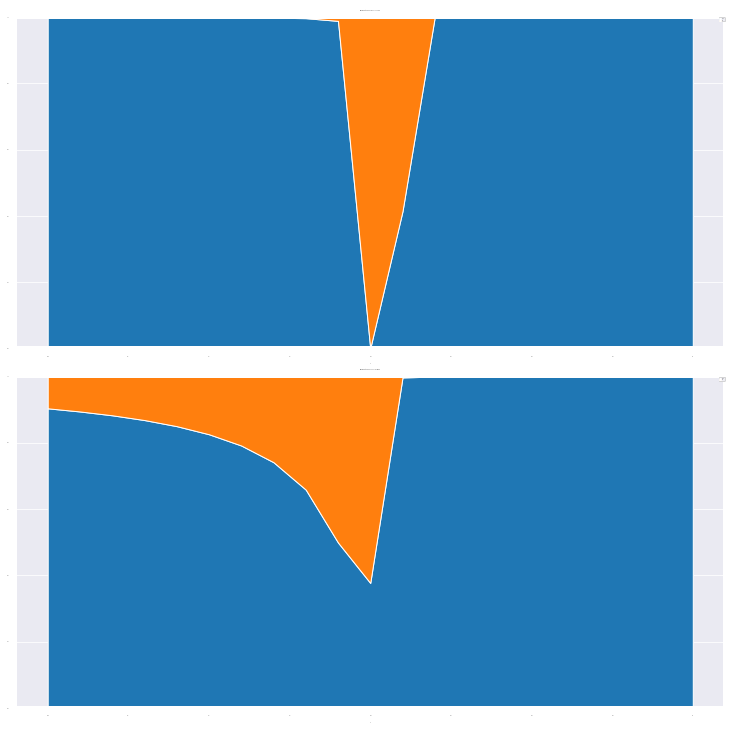

In [22]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
ax1.fill_between(a,share_gamma, label='Uber')
ax1.fill_between(a,share_gamma,np.ones(len(a)), label='Lyft')
ax1.set_xlabel(r'$\tau$')
ax1.set_ylim(0,1)
ax1.set_title(r'Nash Market Share vs. $\tau, \mu_1=\tau*\gamma_1, \gamma_1$ fixed')
ax1.legend()
ax2.fill_between(a,share_mu, label='Uber')
ax2.fill_between(a,share_mu,np.ones(len(a)), label='Lyft')
ax2.set_title(r'Nash Market Share vs. $\tau, \gamma_1=\tau*\mu_1, \mu_1$ fixed')
ax2.set_xlabel(r'$\tau$')
ax2.set_ylim(0,1)
ax2.legend()
plt.tight_layout()
plt.show()